In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
import scipy.io as sio
import curveball

In [2]:
output_path = '../../figures'
data_path = '../../data'
labels = 'IJKL'

In [3]:
mat = sio.loadmat(f'{data_path}/growth/YPD_39deg_RefinedB_vs_TrisomicB.mat')
times = mat['tps'][0] / 60/60
r1 = [0,1,0,1,0,1,0,1,0,1,0,1]
r2 = [1,0,1,0,1,0,1,0,1,0,1,0]
r = [r1,r2,r1,r2,r1,r2,r1,r2]
r = np.array(r).reshape(-1)
r = ['refined' if i==0 else 'trisomic' for i in r]

/Users/adsurbum/opt/miniconda3/envs/py371/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


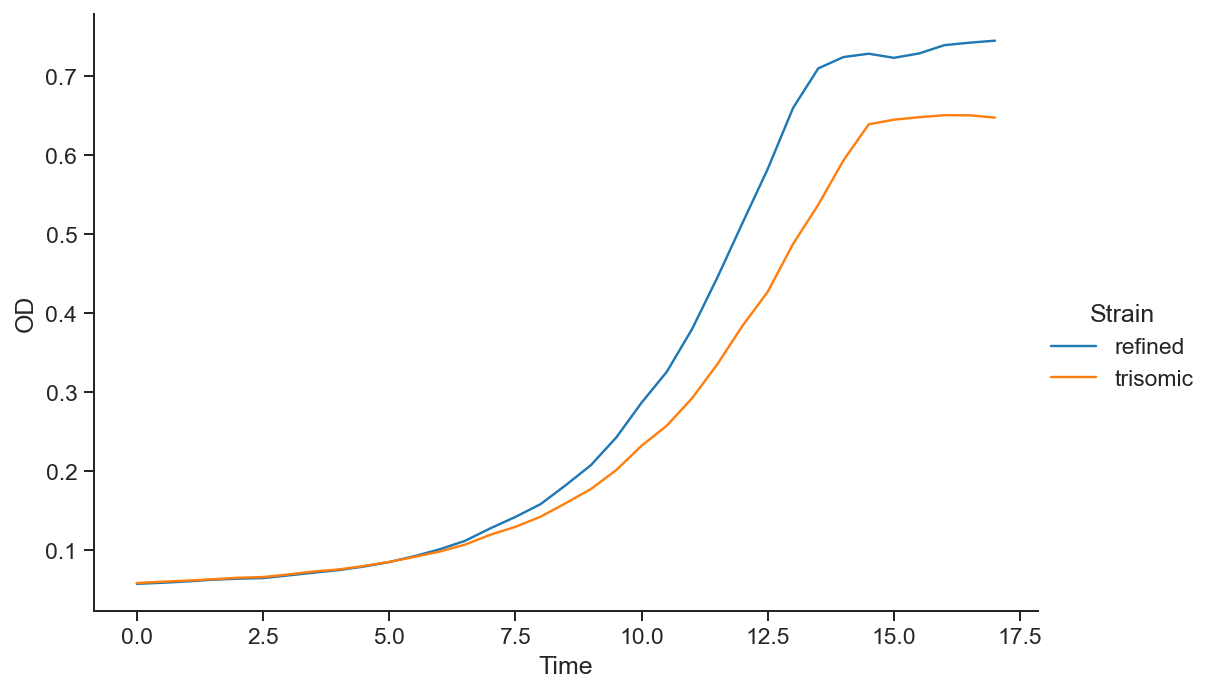

In [4]:
mat = sio.loadmat(f'{data_path}/growth/YPD_39deg_RefinedB_vs_TrisomicB.mat')
plate = mat['plate_mat']
df = pd.DataFrame(data=plate).T
df.columns = list(zip(r,range(96)))
df['Time'] = list(times)
df = pd.melt(df, id_vars='Time', var_name='Strain-Index', value_name='OD')
df['Strain'] = df['Strain-Index'].apply(lambda x:x[0])
df['Index'] = df['Strain-Index'].apply(lambda x:x[1])
df = df[~df['Index'].isin([ 0, 13, 24, 26, 80, 82, 89, 91])] #refined 85% on time 10
df = df[~df['Index'].isin([ 4, 30, 37, 39, 58])] #refined additiona anomalies manual
df = df[~df['Index'].isin([ 1,  3,  9, 11, 12, 33, 36, 60])] #trisomic 85% on time 10
curveball.plots.plot_strains(df)

In [5]:
np.array(times) # we see that times from evo39 excel is pretty simillar, but here is one more

array([ 0.        ,  0.5       ,  0.99972222,  1.50027778,  1.99972222,
        2.50027778,  2.99972222,  3.50027778,  4.        ,  4.5       ,
        5.00027778,  5.49972222,  5.99944444,  6.49944444,  6.99944444,
        7.49972222,  7.99944444,  8.49972222,  8.99944444,  9.49972222,
        9.99944444, 10.49972222, 10.99972222, 11.49972222, 11.99972222,
       12.49972222, 13.        , 13.49944444, 13.99944444, 14.5       ,
       14.99944444, 15.5       , 15.99944444, 16.49972222, 17.        ])

In [6]:
df = df[df['Time'] <= 13]

In [7]:
df_evo30 = df[df['Strain']=='trisomic'] #we are not refactoring the name, it is not evo30 and evo39 ans so on
df_evo39 = df[df['Strain']=='refined']

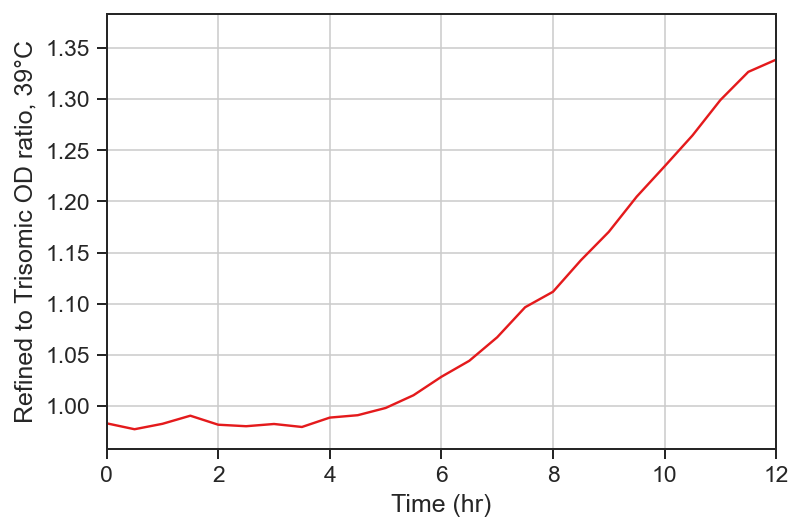

In [8]:
deg = 39
fig, ax = plt.subplots()
od_ratio = df_evo39.groupby('Time').mean() / df_evo30.groupby('Time').mean()
ax.plot(od_ratio.index, od_ratio['OD'], color=red)
ax.set(xlim=(0, 12), xlabel='Time (hr)', ylabel='Refined to Trisomic OD ratio, {}°C'.format(deg))
ax.grid(True);

[[Model]]
    Model(LogisticLag1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 1080
    # variables        = 4
    chi-square         = 0.17525577
    reduced chi-square = 1.6288e-04
    Akaike info crit   = -9416.32315
    Bayesian info crit = -9396.38428
[[Variables]]
    y0:  0.05948200 +/- 8.3703e-04 (1.41%) (init = 0.058695)
    K:   1.80979192 +/- 0.23678090 (13.08%) (init = 0.48781)
    r:   0.36183582 +/- 0.00954590 (2.64%) (init = 0.9925666)
    q0:  0.09885371 +/- 0.01025772 (10.38%) (init = 0.0606466)


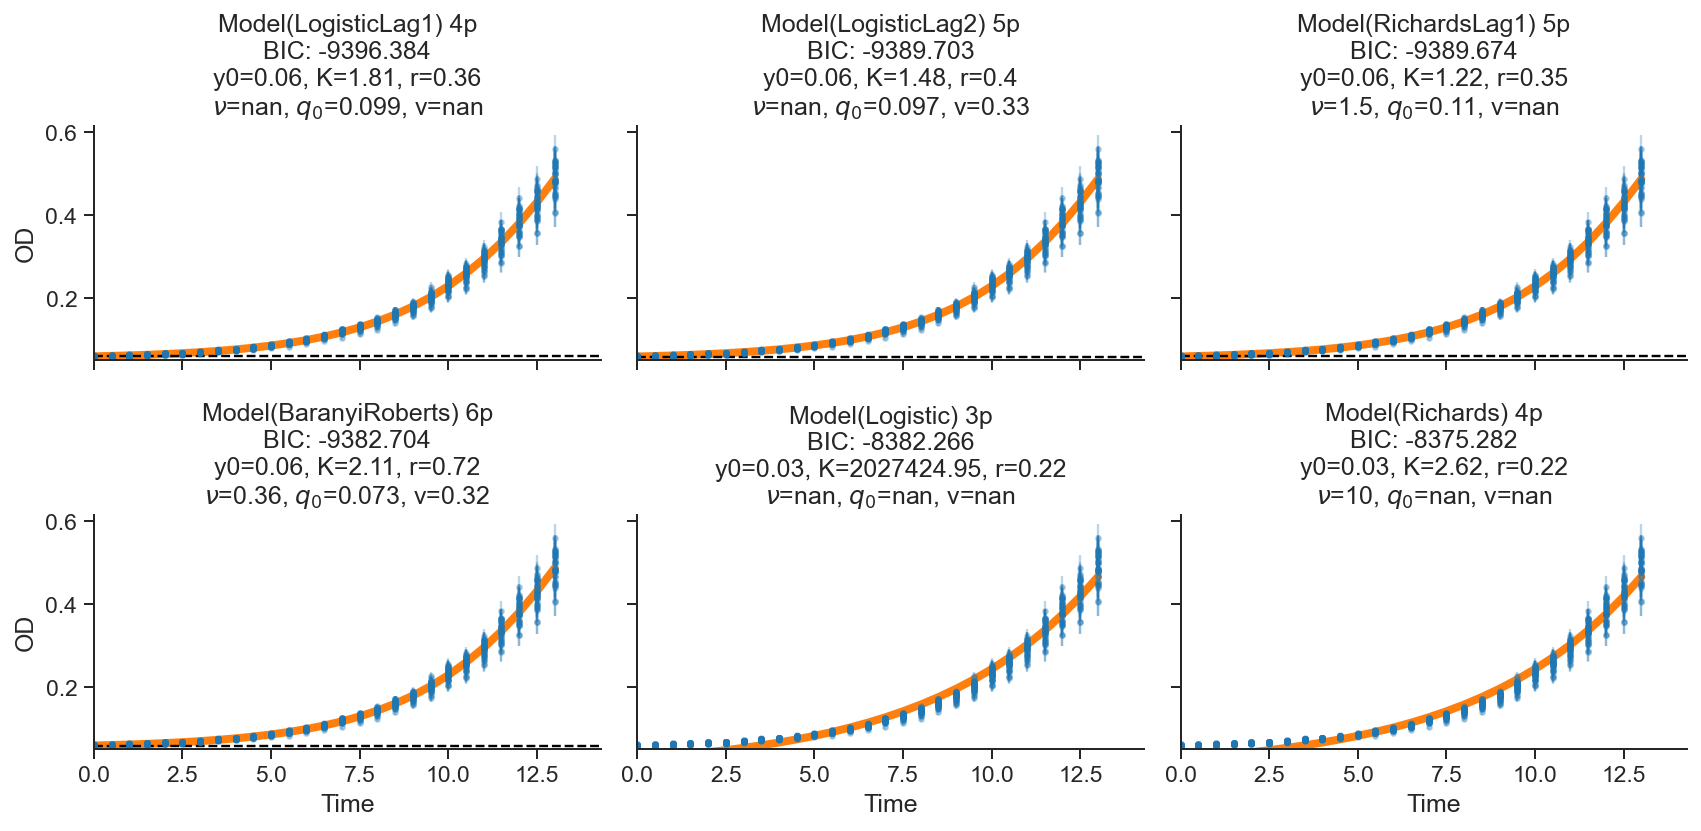

In [9]:
m_evo30, fig, axes = curveball.models.fit_model(df_evo30)

[[Model]]
    Model(LogisticLag1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 945
    # variables        = 4
    chi-square         = 0.20482376
    reduced chi-square = 2.1767e-04
    Akaike info crit   = -7964.76684
    Bayesian info crit = -7945.36210
[[Variables]]
    y0:  0.05931754 +/- 9.4958e-04 (1.60%) (init = 0.05771143)
    K:   1.59270762 +/- 0.08735971 (5.48%) (init = 0.6599629)
    r:   0.43925389 +/- 0.00849446 (1.93%) (init = 1.024203)
    q0:  0.06126489 +/- 0.00585653 (9.56%) (init = 0.06081321)


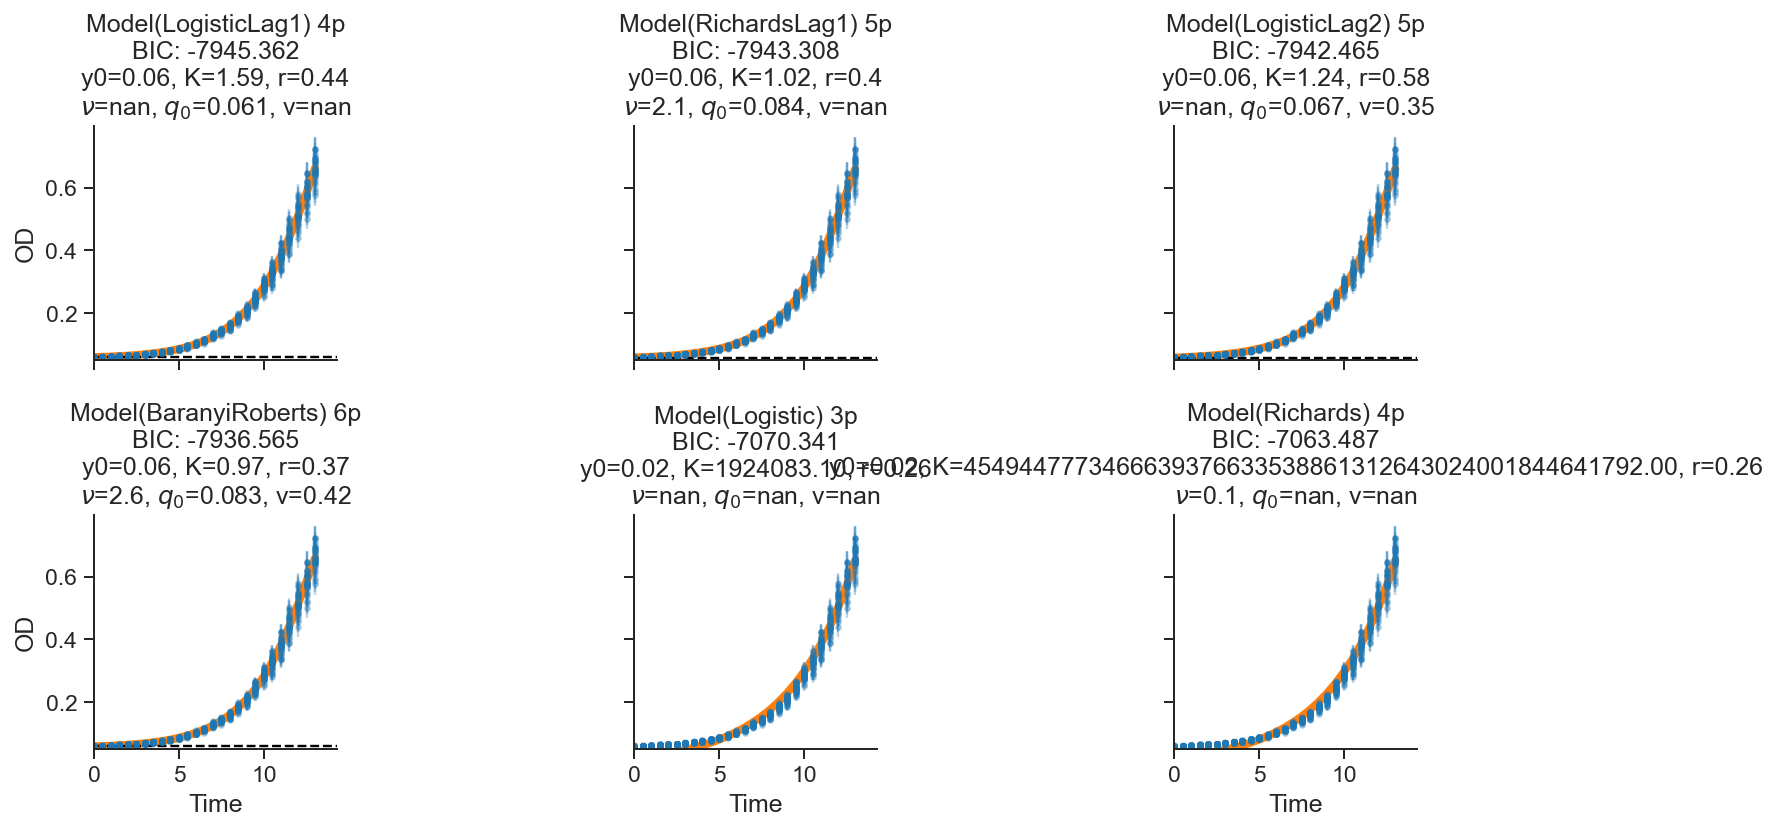

In [10]:
m_evo39, fig, axes = curveball.models.fit_model(df_evo39)

In [11]:
y0 = (m_evo30[0].params['y0'].value, m_evo39[0].params['y0'].value)
print(y0)
y0 = np.mean(y0)/2, np.mean(y0)/2
print(y0)

(0.05948199531742171, 0.05931754124750355)
(0.029699884141231314, 0.029699884141231314)


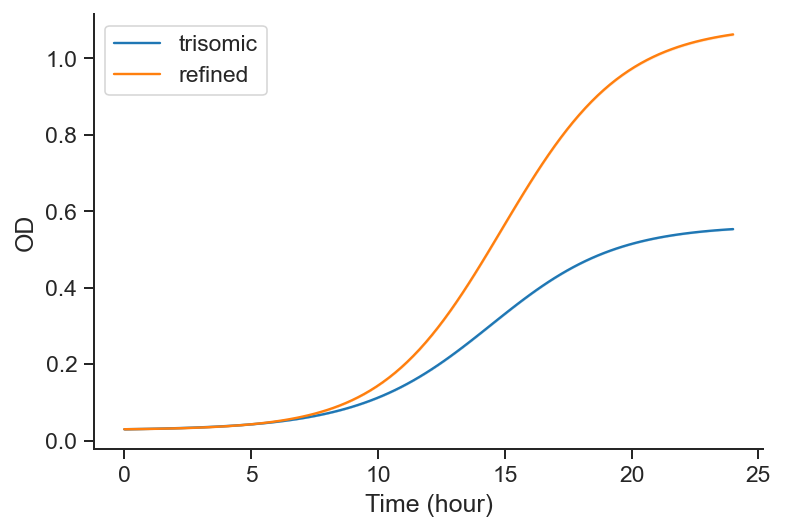

In [12]:
t, y, fig, ax = curveball.competitions.compete(m_evo30[0], m_evo39[0], y0=y0, PLOT=True, nsamples=10000)
# y = y.squeeze()
ax.legend(['trisomic', 'refined']);

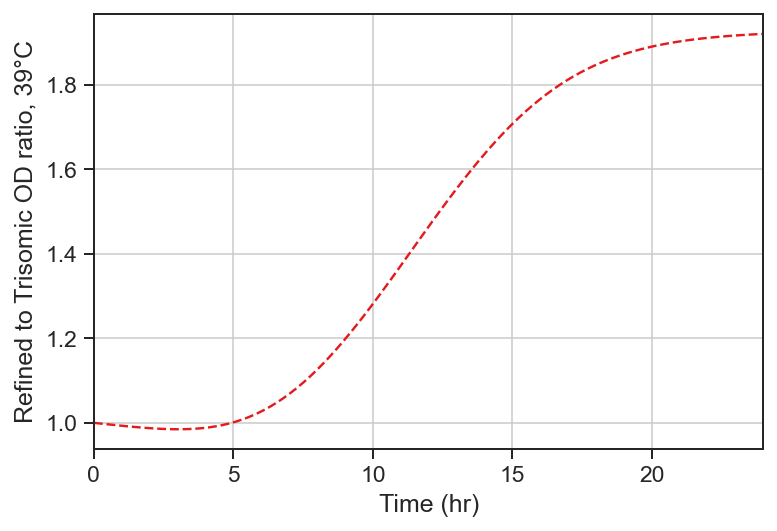

In [13]:
fig, ax = plt.subplots()

od_ratio_hat = y[:, 1].mean(axis=1)/y[:, 0].mean(axis=1)
ax.plot(t, od_ratio_hat, color=red, ls='--')
# ax.plot(od_ratio.index, od_ratio['OD'], color=red)
ax.set(xlim=(0, 24), xlabel='Time (hr)', ylabel='Refined to Trisomic OD ratio, 39°C')
ax.grid(True)

/Users/adsurbum/opt/miniconda3/envs/py371/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


w = 1.0336 (95% CI 1.0266 - 1.0416)


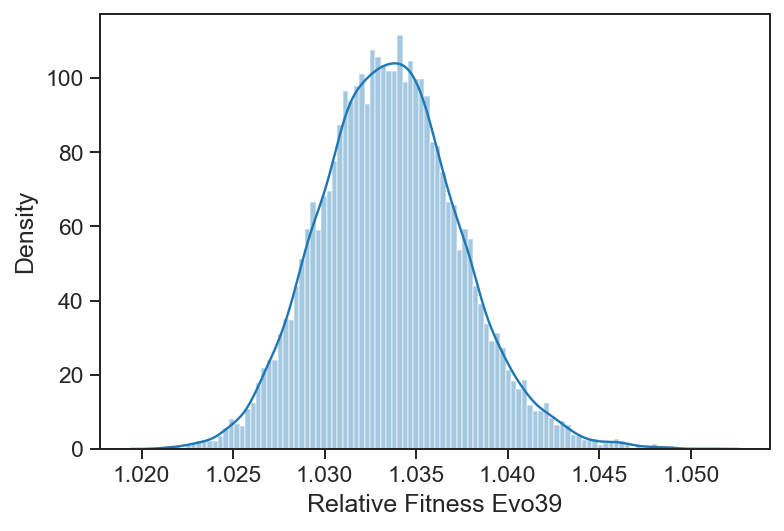

In [14]:
w = np.array([curveball.competitions.fitness_LTEE(y[:,:,i]) for i in range(y.shape[2])])
s = w - 1
s  /= np.log2(100) # convert from 24 hr to generations
w = 1 + s
ax = sns.distplot(w, bins=100, kde=True)
ax.set(xlabel='Relative Fitness Evo39', ylabel='Density');
print("w = {:.4f} (95% CI {:.4f} - {:.4f})".format(
    w.mean(), np.percentile(w, 2.5), np.percentile(w, 97.5)
))

In [15]:
# np.savez_compressed('refined_vs_evo39_fitness_{}deg.npz'.format(deg), w)

/Users/adsurbum/opt/miniconda3/envs/py371/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


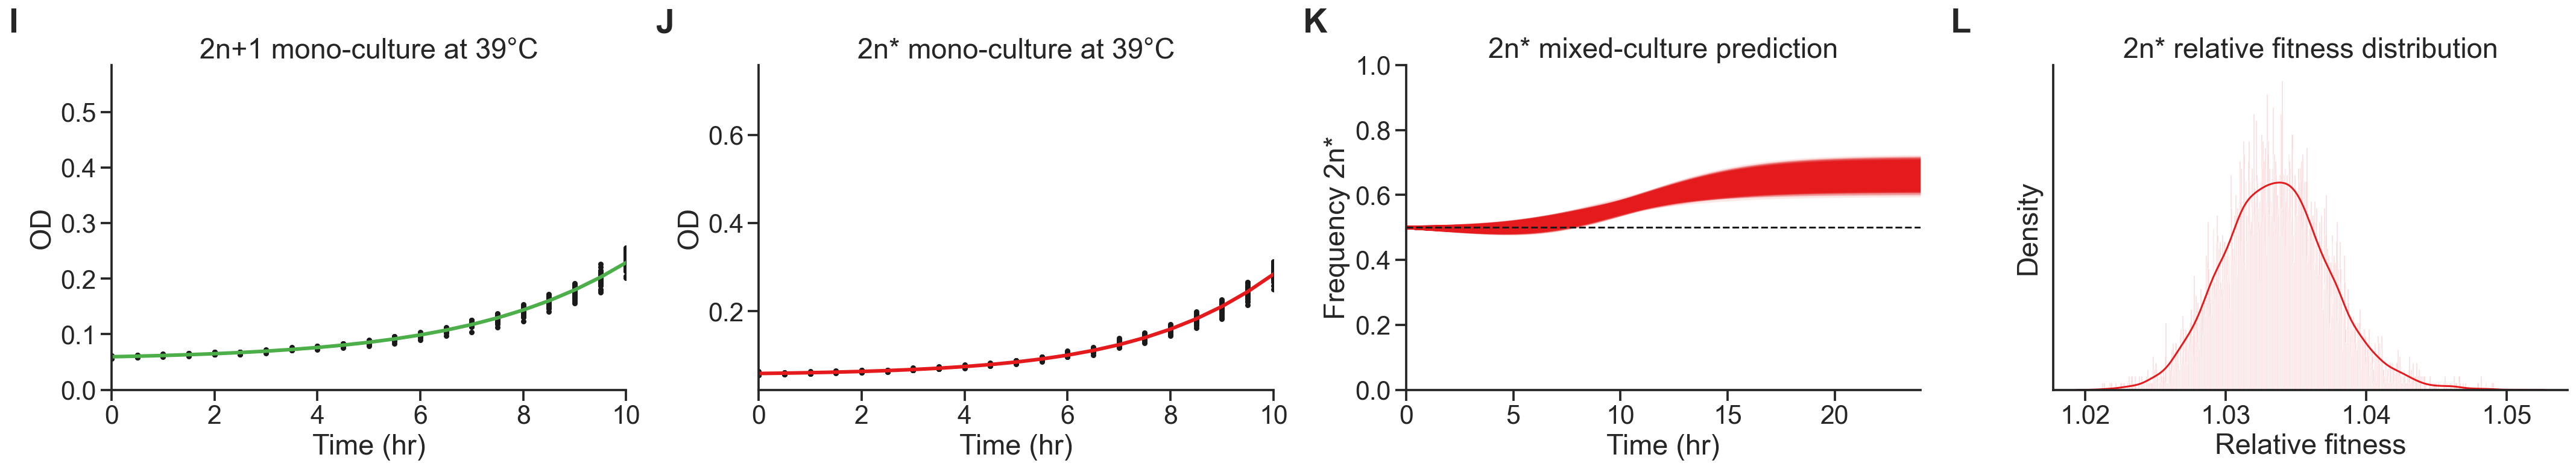

In [16]:
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 1.5, 'lines.markersize': 7},font_scale=1.3)

fig, axes = plt.subplots(1, 4, figsize=(30, 6))
# mono-culture
data_kws = dict(color='k', marker='.')
evo30_kws = dict(color=green, lw=3)
evo39_kws = dict(color=red, lw=3)
m_evo30[0].plot_fit(ax=axes[0], fit_kws=evo30_kws, data_kws=data_kws)
m_evo39[0].plot_fit(ax=axes[1], fit_kws=evo39_kws, data_kws=data_kws)
for ax in axes[0:1]:
    ax.set(xlim=(0, None), ylim=(0, None))
axes[0].set(title="2n+1 mono-culture at 39°C", ylabel='OD', xlabel='Time (hr)', xlim=(0,10))
axes[1].set(title="2n* mono-culture at 39°C", ylabel='OD', xlabel='Time (hr)', xlim=(0,10))

# competition
axes[2].plot(t, y[:,1,:]/y.sum(axis=1), **evo39_kws, alpha=0.1)
axes[2].set(title="2n* mixed-culture prediction", ylabel='Frequency 2n*', xlim=(0,24), ylim=(0,1), xlabel='Time (hr)')
axes[2].axhline(0.5, ls='--', color='k')

# fitness
sns.distplot(w, bins=1000, kde=True, color=red,  ax=axes[3])
axes[3].set(title='2n* relative fitness distribution', xlabel='Relative fitness', ylabel='Density')
axes[3].set_ylabel('Density', labelpad=10)
axes[3].axes.yaxis.set_ticks([])

# leftovers
for ax in axes.flat:
    ax.legend().set_visible(False)   
    
sns.despine()
axes[0].text(-0.2, 1.1, labels[0], transform=axes[0].transAxes, size=28, weight='bold')
axes[1].text(-0.2, 1.1, labels[1], transform=axes[1].transAxes, size=28, weight='bold')
axes[2].text(-0.2, 1.1, labels[2], transform=axes[2].transAxes, size=28, weight='bold')
axes[3].text(-0.2, 1.1, labels[3], transform=axes[3].transAxes, size=28, weight='bold')
fig.tight_layout()
fig.savefig(f'{output_path}/refined_vs_evo39_fitness_{deg}deg.pdf')